# Bayesian Knowledge Tracing 
#### BKT for inferring human knowledge on a procedural task like programming

In [1]:
import numpy as np
import pandas as pd
import math
import itertools
from collections import defaultdict 
import copy
from pyBKT.generate import synthetic_data, random_model_uni
from pyBKT.fit import EM_fit
from copy import deepcopy
import matplotlib.pyplot as plt

### Importing the collected data
Our data is collected in 3 phases:
1. Pre-test (3 questions)
2. Training (6 questions)
3. Post-test (3 questions)

In [42]:
# Learning sequences (performance of each student on training data)
training_data = {
's1' : [1,0,1,1,1,0], # Blocked
's2' : [0,0,1,1,0,0], # Blocked
's3' : [0,0,1,0,1,1], # Blocked
's4' : [0,0,0,1,1,1], # Blocked
's5' : [0,1,1,1,1,1], # Blocked
's6' : [0,0,1,1,1,1], # Blocked
's7' : [1,0,1,1,1,1], # Blocked
's8' : [1,0,1,1,1,1], # Blocked
's9' : [1,0,1,0,0,1], # Blocked
's10' : [0,1,0,1,1,1], # Blocked
's11' : [1,0,0,1,1,1], # Blocked
's12' : [1,0,0,1,1,1], # Blocked
    
's13' : [1,0,1,0,1,1], # Interleaved
's14' : [0,0,0,1,1,0], # Interleaved
's15' : [1,0,1,0,0,0], # Interleaved
's16' : [1,0,0,1,1,0], # Interleaved
's17' : [0,0,0,1,1,1], # Interleaved
's18' : [1,0,0,1,1,1], # Interleaved
's19' : [0,1,1,1,0,1], # Interleaved
's20' : [0,0,0,0,1,0], # Interleaved
's21' : [1,0,0,1,0,0], # Interleaved
's22' : [0,0,0,1,1,0], # Interleaved
's23' : [0,0,1,0,1,1] # Interleaved

}

# Post-Test scores of each student
test_data = {
's1' : 22,
's2' : 10,
's3' : 20,
's4' : 30,
's5' : 30,
's6' : 30,
's7' : 30,
's8' : 20,
's9' : 23.3,
's10' : 30,
's11' : 30,
's12' : 26,
    
's13' : 24,
's14' : 10,
's15' : 20,
's16' : 19,
's17' : 20,
's18' : 30,
's19' : 30,
's20' : 22,
's21' : 10,
's22' : 10,
's23' : 15
}


## Parameter Estimation in BKT
Here we are learning the parameters of the BKT Model using EM algorithm and then comparing it with the empirically obtained parameter values

In [43]:
# parameters classes
num_gs = 1 #number of guess/slip classes
num_learns = 1 #number of learning rates

# State the prior probabilities
p_T = 0.30
p_F = 0.00
p_G = 0.10
p_S = 0.30
p_L0 = 0.15

In [44]:
# Data conversion for parmater learning in BKT
lst = sum(list(training_data.values()), [])
lst_ = []
for i in lst:
    if i == 0:
        lst_.append(1)
    else:
        lst_.append(2)

In [45]:
#generate synthetic model and data.
truemodel = {}

truemodel["As"] =  np.zeros((num_learns,2,2), dtype=np.float_)
for i in range(num_learns):
    truemodel["As"][i] = np.transpose([[1-p_T, p_T], [p_F, 1-p_F]])

In [46]:
truemodel["learns"] = truemodel["As"][:,1, 0,]
truemodel["forgets"] = truemodel["As"][:,0, 1]

truemodel["pi_0"] = np.array([[1-p_L0], [p_L0]])
truemodel["prior"] = truemodel["pi_0"][1][0]

In [47]:
truemodel["guesses"] = np.full(num_gs, p_G, dtype=np.float_)
truemodel["slips"] = np.full(num_gs, p_S, dtype=np.float_)
#can optionally set learn class sequence - set randomly by synthetic_data if not included
#truemodel["resources"] = np.random.randint(1, high = num_resources, size = sum(observation_sequence_lengths))

#data!
print("generating data...")

#specifies 500 students with 100 observations for synthetic data
# observation_sequence_lengths = np.full(500, 100, dtype=np.int) 
# data = synthetic_data.synthetic_data(truemodel, observation_sequence_lengths)
data = {
    'data':np.array(lst_).reshape((1,len(lst_))),
    'starts':np.array(list(range(1, len(lst)+1, 6))),
    'lengths':np.array(len(list(range(1, len(lst)+1, 6)))*[6]),
    'resources':np.array(len(lst_)*[1])    
}

generating data...


In [48]:
#fit models, starting with random initializations
print('fitting! each dot is a new EM initialization')

num_fit_initializations = 5
best_likelihood = float("-inf")

for i in range(num_fit_initializations):
    # include this line to randomly set initial param values
	fitmodel = random_model_uni.random_model_uni(num_learns, num_gs) 
	(fitmodel, log_likelihoods) = EM_fit.EM_fit(fitmodel, data)
	if(log_likelihoods[-1] > best_likelihood):
		best_likelihood = log_likelihoods[-1]
		best_model = fitmodel

fitting! each dot is a new EM initialization


In [49]:
# compare the fit model to the true model

print('')
print('\ttruth\tlearned')
print('prior\t%.4f\t%.4f' % (truemodel['prior'], best_model["pi_0"][1][0]))
for r in range(num_learns):
    print('learn%d\t%.4f\t%.4f' % (r+1, truemodel['As'][r, 1, 0].squeeze(), best_model['As'][r, 1, 0].squeeze()))
for r in range(num_learns):
    print('forget%d\t%.4f\t%.4f' % (r+1, truemodel['As'][r, 0, 1].squeeze(), best_model['As'][r, 0, 1].squeeze()))

for s in range(num_gs):
    print('guess%d\t%.4f\t%.4f' % (s+1, truemodel['guesses'][s], best_model['guesses'][s]))
for s in range(num_gs):
    print('slip%d\t%.4f\t%.4f' % (s+1, truemodel['slips'][s], best_model['slips'][s]))


	truth	learned
prior	0.1500	0.0009
learn1	0.3000	0.2579
forget1	0.0000	0.0000
guess1	0.1000	0.3632
slip1	0.3000	0.2240


In the learned values for the parameters, we can see that most of the learned values do fall in the range of empirical/true parameter values. We can attribute the large value of Guess to the fact that our questions were in a format (easy, hard, easy, hard) so it might lead to sequences like (0, 1, 0, 1) which is why we believe the guess probability is higher. 

## Here we are doing Inference using the priors obtained empirically 

In [50]:
# Inference using BKT
# https://dl.acm.org/doi/pdf/10.1145/1595496.1562972
# Prior probabilities


class BKT_Inference:
    def __init__(self, p_T, p_F, p_G, p_S, p_L0, data, test_data):
        self.p_T = p_T
        self.p_F = p_F
        self.p_G = p_G
        self.p_S = p_S
        self.p_L0 = p_L0
        self.copy_p_L0 = p_L0
        self.learning_data = data
        self.test_data = test_data
        self.learn_step = {}


    def update_knowledge(self, response):
        if response == 0:
            p_L = (self.p_L0 * self.p_S) / ((self.p_L0 * self.p_S) + ((1 - self.p_L0)*(1 - self.p_G)))
        else:
            p_L = (self.p_L0 * (1 - self.p_S)) / ((self.p_L0 * (1 - self.p_S)) + ((1 - self.p_L0)*self.p_G))
        return p_L


    def transition(self, prior):
        posterior = prior + (1-prior)*self.p_T
        return posterior


    def inference(self):
        learning = {}
        for student, questions in self.learning_data.items():
            temp = []
            for question in questions:
                #update the knowledge
                prior = self.update_knowledge(question)
                # update the posterior
                posterior = self.transition(prior)
                self.p_L0 = posterior
                temp.append(posterior)
            # update the learning posterior at the end of the sequence
            learning.update({student:posterior})
            # store learning at each step
            self.learn_step.update({student:temp})
            # reinitialize the knowledge prior for a new student
            self.p_L0 = self.copy_p_L0
        return learning, self.learn_step
    
    
    def comparison(self):
        a, b = self.inference()
        learning_scores = list(a.values())
        test_scores = list(self.test_data.values())
        test_scores = [l/max(test_scores) for l in test_scores]       
        plt.figure(figsize=(20,10))
        plt.plot(range(0,int(len(learning_scores))), learning_scores, label="posterior_knowledge")
        plt.plot(range(0,int(len(test_scores))), test_scores, label="true_test_scores")
        plt.grid()
        plt.title("Comparison")
        plt.xlabel("students")
        plt.legend()
        plt.show()
    
    def knowledge_plot(self):
        i = 1
        plt.figure(figsize=(20,10))
        for k,v in self.learn_step.items():
            plt.plot(range(0, len(v)), v, label="student:"+str(i))
            i+= 1
        plt.grid()
        plt.title("Knowledge Plots")
        plt.xlabel("Questions")
        plt.ylabel("Performance")
        plt.legend()
        plt.show()


        
# Instantiate the BKT class
bkt_class = BKT_Inference(p_T, p_F, p_G, p_S, p_L0, training_data, test_data)
# Calculating the learning for each student
posterior, posterior_per_step = bkt_class.inference()




### Plot showing a comparison for posterior knowledge (found using BKT) v/s empirical post-test scores
Here we are comparing the post-test scores for each student to their knowledge traced during the learning phase. We want to understand, Is Post-test score a good representation of actual knowledge gained by the students during the training phase.  

On X-axis we have students (0-24) and y-axis is their normalized scores.
The blue line represents the posterior knowledge inferred using BKT.
The Orange line represents the post-test score for each student. 

Students from 0-12 on x-axis belong to the Blocked Group.
Students from 12-24 on x-axis belong to the Interleaved Group. 

#### Results
1. We can note from the graph that although the knowledge gained was higher for each student, their performance was not as high on the post-test.
2. However, we do see some correlation between the post-test and latent knowledge for each student. 
3. For students in BLOCKED category (0-12 on x-axis), the latent knowledge is higher and so is their post-test performance.
4. For students in INTERLEAVED categorgy (12-24 on x-axis), the latent knowledge is relatively lower and fluctuating and so is their post-test scores as compared to the students in BLOCKED category.

##### The high variance in the plots is due to less amount of data and small sequences.


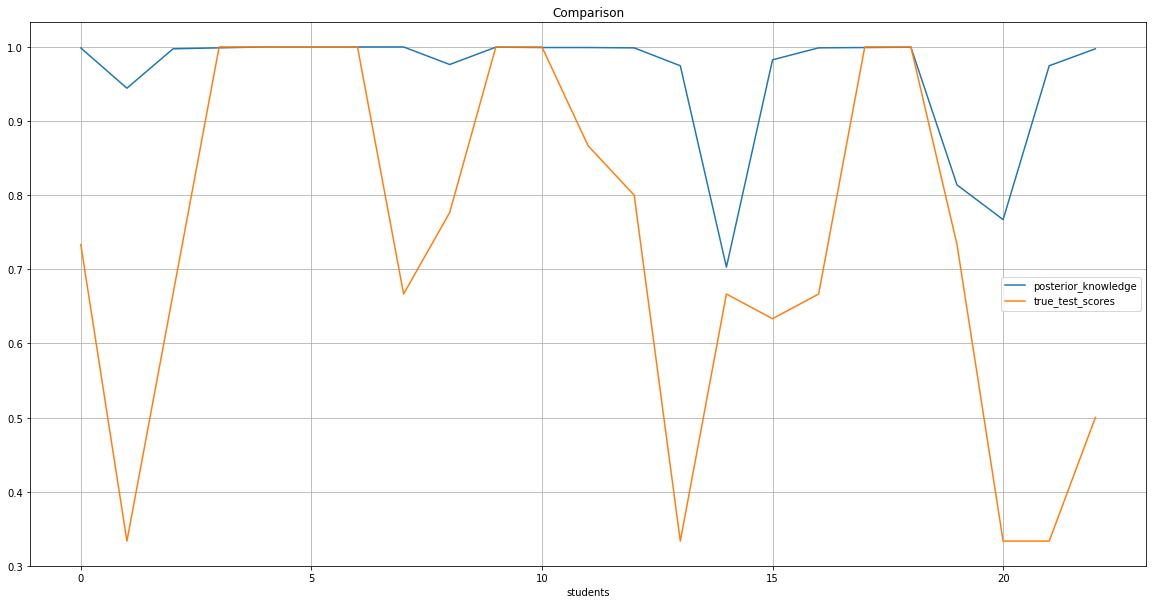

In [51]:
# Plot the comparison
bkt_class.comparison()

### Plot showing the latent knowledge for each student 
In this plot each line shows a student and the X-axis are the 6 training questions that they trained themselves on. Each line shows the increment/decrement in the latent knowledge as the students progresses through training sequences. 

We can see that for some students there is a steady increase in the latent knowledge as they see more questions.  These students belong to the BLOCKED category. The remaining students whose knowledge declined or didn't increase much belonged to the INTERLEAVED category.

Also the BLOCKED students seem to converge faster than INTERLEAVED students.

##### Again, the high variance can be attributed to the smaller sequences.

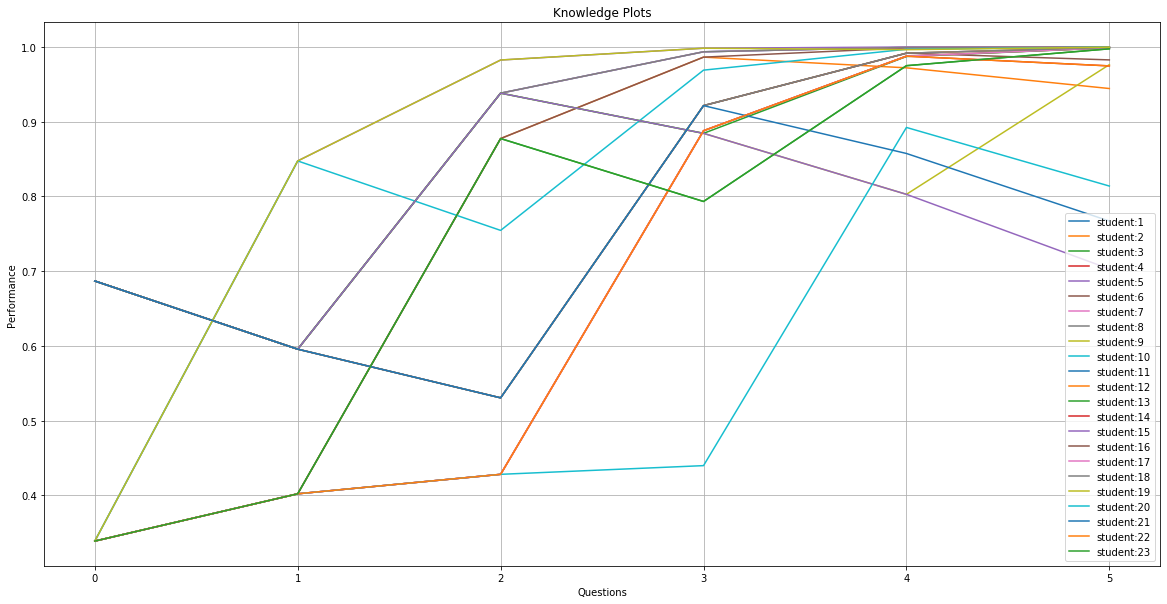

In [52]:
# Plot the knowledge plots
bkt_class.knowledge_plot()